In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
!{sys.executable} -m pip install keras pandas numpy image matplotlib scikit-learn

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator , load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./test_set/test_set"))

['cats', 'dogs', 'test', 'train']


In [4]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [5]:
# Preparing Traning Data
catsnames = os.listdir("./test_set/test_set/cats")
dogsnames = os.listdir("./test_set/test_set/dogs")
filenames = catsnames + dogsnames
categories = []
for filename in catsnames:
    category = filename.split('.')[0]
    categories.append(0)
    
for filename in dogsnames:
    category = filename.split('.')[0]
    categories.append(1)
    
df = pd.DataFrame({
    'filename': catsnames+dogsnames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,cat (1).jpg,0
1,cat (10).jpg,0
2,cat (100).jpg,0
3,cat (1000).jpg,0
4,cat (10000).jpg,0


In [7]:
df.tail()

,filename,category
24995,dog (9995).jpg,1
24996,dog (9996).jpg,1
24997,dog (9997).jpg,1
24998,dog (9998).jpg,1
24999,dog (9999).jpg,1


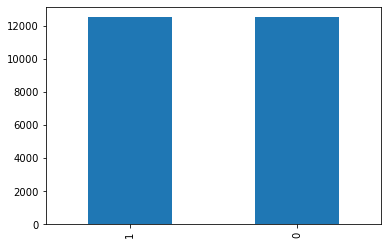

In [8]:
df['category'].value_counts().plot.bar()

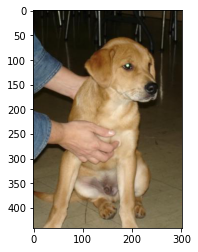

In [9]:
# See sample Image
sample = random.choice(filenames)
image = load_img("./test_set/test_set/train/"+sample)
plt.imshow(image)

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [11]:
# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
# Early Stop
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

In [13]:
# Learning Rate Reduction
# We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

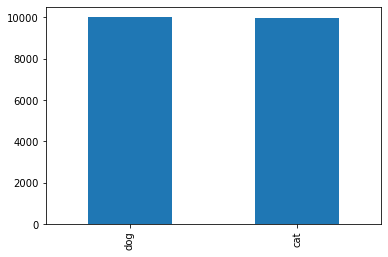

In [17]:
train_df['category'].value_counts().plot.bar()

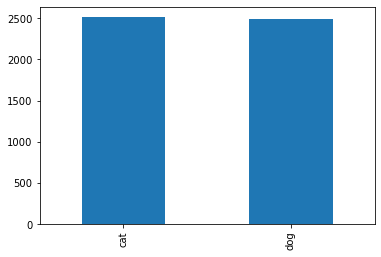

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [20]:
# Train Generator
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./test_set/test_set/train/",
    x_col = "filename",
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [21]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./test_set/test_set/train/",
    x_col = "filename",
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [22]:
# See how our generator work
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "./test_set/test_set/train/",
    x_col = "filename",
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
)

Found 1 validated image filenames belonging to 1 classes.


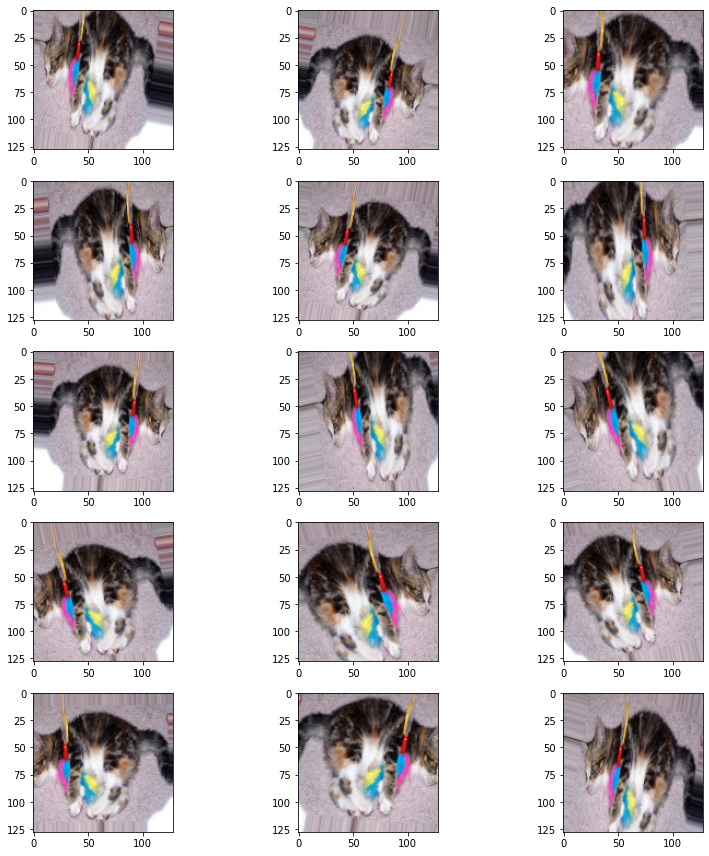

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [134]:
# Fit model
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/50
107/107 [==============================] - 43s 397ms/step - loss: 1.2734 - accuracy: 0.5560 - val_loss: 1.7163 - val_accuracy: 0.5161
Epoch 2/50
107/107 [==============================] - 41s 384ms/step - loss: 0.9888 - accuracy: 0.5629 - val_loss: 0.6902 - val_accuracy: 0.5484
Epoch 3/50
107/107 [==============================] - 41s 386ms/step - loss: 0.8346 - accuracy: 0.5899 - val_loss: 1.2148 - val_accuracy: 0.5161
Epoch 4/50
107/107 [==============================] - 41s 383ms/step - loss: 0.7491 - accuracy: 0.5986 - val_loss: 0.6379 - val_accuracy: 0.6005
Epoch 5/50
107/107 [==============================] - 41s 388ms/step - loss: 0.6904 - accuracy: 0.6230 - val_loss: 0.7852 - val_accuracy: 0.5658
Epoch 6/50
107/107 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.6393
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
107/107 [==============================] - 42s 389ms/step - loss: 0.6663 - accuracy: 0.6393 - val_l

In [135]:
model.save_weights("model101.h5")

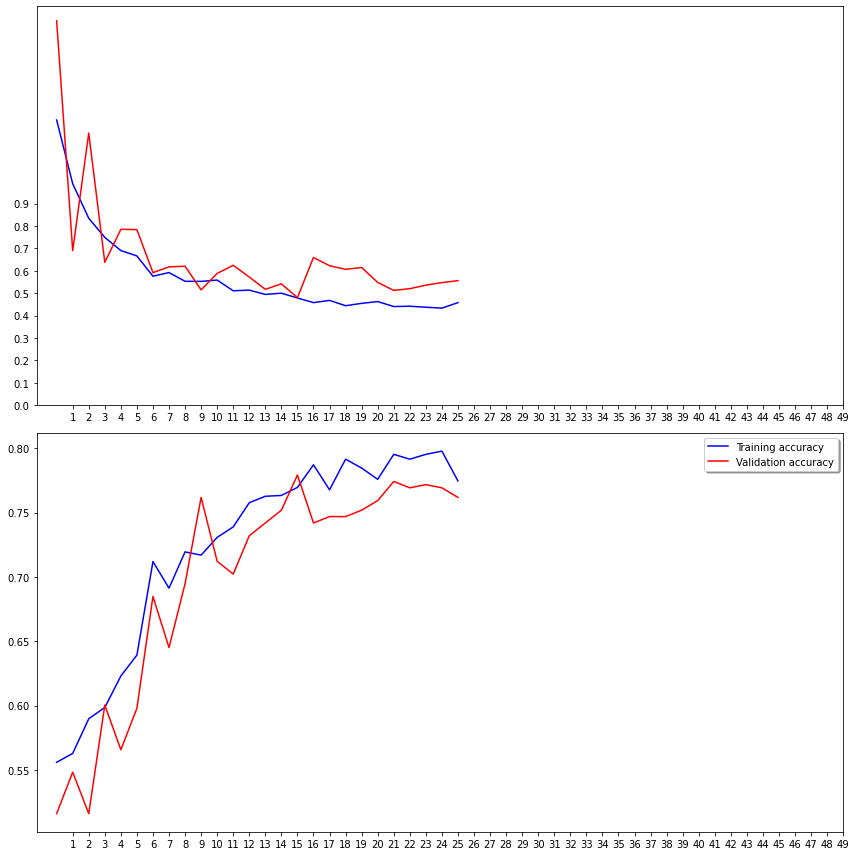

In [136]:
# Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [24]:
test_filenames = os.listdir("./test_set/test_set/test")
test_df = pd.DataFrame({
    'filename' : test_filenames
})
nb_samples = test_df.shape[0]

In [26]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    "./test_set/test_set/test",
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

AttributeError: 'str' object has no attribute 'copy'

In [27]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

NameError: name 'test_generator' is not defined

In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

NameError: name 'predict' is not defined

In [29]:
test_df['category'] = test_df['category'].replace({'dog' : 1, 'cat' : 0})

KeyError: 'category'

In [30]:
test_df['category'].value_counts().plot.bar()

KeyError: 'category'

In [31]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12,24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('./test_set/test_set/test' + filename, target_size = IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
    plt.tight_layout()
    plt.show()

KeyError: 'category'

<Figure size 864x1728 with 0 Axes>